## PREDIKSI RISIKO SAHAM PERUSAHAAN DI SUMATERA BAGIAN SELATAN MENGGUNAKAN METODE ACCEPTANCE-REJECTION DAN INVERSE TRANSFORM

**Masalah:**

Masalah yang diangkat adalah ketidakpastian dalam pasar keuangan. Kita tahu bagaimana portofolio saham (PTBA, SMBR, RMKE) berperilaku di masa lalu (data 4 tahun terakhir), tetapi tidak tahu sama sekali apa yang kemungkinan akan terjadi besok, minggu depan, atau bulan depan.

**Pertanyaan:**

1. "Seberapa besar risiko portofolio ini dalam 30 hari ke depan?"
2. "Seberapa yakin terhadap risiko yang akan didapatkan?"

**Tujuan:**

Mengukur risiko secara kuantitatif menggunakan metode pembangkitan bilangan acak **Acceptance-Rejection** dan **Inverse Transform** untuk mensimulasikan return portofolio berbasis distribusi-t Student.

**Metode yang Digunakan:**

1. **Inverse Transform Method**: Untuk membangkitkan bilangan acak uniform U(0,1)
2. **Acceptance-Rejection Method**: Untuk membangkitkan bilangan acak dari distribusi-t Student menggunakan distribusi proposal Cauchy

In [1]:
# Run sekali saja
install.packages("tidyquant")
install.packages("dplyr")
install.packages("ggplot2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘globals’, ‘listenv’, ‘parallelly’, ‘mvtnorm’, ‘pcaPP’, ‘DEoptimR’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘sparsevctrs’, ‘furrr’, ‘crosstalk’, ‘warp’, ‘BH’, ‘colorspace’, ‘fracdiff’, ‘lmtest’, ‘tseries’, ‘urca’, ‘RcppArmadillo’, ‘RcppRoll’, ‘future’, ‘quadprog’, ‘pyinit’, ‘rrcov’, ‘robustbase’, ‘recipes’, ‘rsample’, ‘plotly’, ‘padr’, ‘slider’, ‘anytime’, ‘forecast’, ‘tsfeatures’, ‘lazyeval’, ‘PerformanceAnalytics’, ‘RobStatTM’, ‘quantmod’, ‘timetk’, ‘timeDate’, ‘TTR’, ‘xts’, ‘zoo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
# MUAT LIBRARY

# Suppress semua warning messages
options(warn = -1)
suppressMessages(suppressWarnings({
  library(tidyquant)  # Untuk mengunduh data saham
  library(scales)
  library(dplyr)      # Untuk manipulasi data
  library(ggplot2)    # Untuk plotting
  library(tidyr)      # Untuk membersihkan data
  library(stringr)    # Untuk manipulasi string
}))

cat("Library berhasil dimuat!\n")

Library berhasil dimuat!


In [3]:
# TENTUKAN PORTFOLIO & UNDUH DATA

tickers <- c("PTBA.JK", "SMBR.JK", "RMKE.JK")
dari_tanggal <- Sys.Date() - (4 * 365) # 4 tahun lalu
ke_tanggal <- Sys.Date()

cat(paste("Menampilkan data untuk:", paste(tickers, collapse=", ")),"\n")
cat("------------------------------------------------","\n")

# tq_get akan mengunduh data dan menyimpannya dalam format 'tidy' (long)
price_data <- suppressWarnings(suppressMessages(
  tq_get(tickers,
         get = "stock.prices",
         from = dari_tanggal,
         to = ke_tanggal) %>%
    select(symbol, date, adjusted) # hanya butuh harga penutupan
))

cat("6 baris pertama:","\n")
print.data.frame(head(price_data))

Menampilkan data untuk: PTBA.JK, SMBR.JK, RMKE.JK 
------------------------------------------------ 
6 baris pertama: 
   symbol       date adjusted
1 PTBA.JK 2021-11-29 1223.053
2 PTBA.JK 2021-11-30 1195.466
3 PTBA.JK 2021-12-01 1195.466
4 PTBA.JK 2021-12-02 1259.837
5 PTBA.JK 2021-12-03 1246.043
6 PTBA.JK 2021-12-06 1264.435


In [4]:
# HITUNG RETURN & STATISTIK KUNCI

# Gunakan return logaritmik (standar di R)
# tq_transmute akan menghitung return harian untuk setiap saham
returns_data_long <- suppressWarnings(suppressMessages(
  price_data %>%
    group_by(symbol) %>%
    tq_transmute(select = adjusted,
                 mutate_fun = periodReturn,
                 period = "daily",
                 type = "log") %>%
    na.omit()
))

# data 'wide' (lebar) untuk matriks kovarians
returns_data_wide <- returns_data_long %>%
  pivot_wider(names_from = symbol, values_from = daily.returns) %>%
  na.omit() %>%
  select(-date) # Hapus kolom tanggal

cat("\n")
cat("Return harian berhasil dihitung:","\n")
cat("-------------------------------------","\n")
cat("Format long:","\n")
print.data.frame(head(returns_data_long))
cat("\n")
cat("Format wide:","\n")
print.data.frame(head(returns_data_wide))
cat("\n")

# Rata-rata return harian
mean_returns <- colMeans(returns_data_wide)
cat("Rata-rata Return Harian:","\n")
cat("-------------------------------------","\n")
print(mean_returns)
cat("\n")

# Matriks Kovarians
cov_matrix <- cov(returns_data_wide)
cat("Matriks Kovarians:","\n")
cat("-------------------------------------","\n")
print(cov_matrix)


Return harian berhasil dihitung: 
------------------------------------- 
Format long: 
   symbol       date daily.returns
1 PTBA.JK 2021-11-29    0.00000000
2 PTBA.JK 2021-11-30   -0.02281466
3 PTBA.JK 2021-12-01    0.00000000
4 PTBA.JK 2021-12-02    0.05244646
5 PTBA.JK 2021-12-03   -0.01100918
6 PTBA.JK 2021-12-06    0.01465223

Format wide: 
       PTBA.JK      SMBR.JK     RMKE.JK
1  0.000000000 -0.007067098  0.00000000
2 -0.010969020 -0.014285997 -0.01511359
3  0.000000000  0.000000000  0.00000000
4  0.007325968  0.000000000  0.16353365
5 -0.011009177  0.021353095 -0.02620236
6  0.007352902 -0.028573363 -0.02690744

Rata-rata Return Harian: 
------------------------------------- 
      PTBA.JK       SMBR.JK       RMKE.JK 
 0.0006323422 -0.0009325435  0.0030448548 

Matriks Kovarians: 
------------------------------------- 
             PTBA.JK      SMBR.JK      RMKE.JK
PTBA.JK 4.336013e-04 5.952501e-05 4.165175e-05
SMBR.JK 5.952501e-05 7.643476e-04 1.693557e-05
RMKE.JK 4.165175e-0

In [5]:
# PEMBANGKITAN BILANGAN ACAK MENGGUNAKAN ACCEPTANCE-REJECTION METHOD

jumlah_simulasi <- 10000 # 10 Ribu
jumlah_hari <- 30
portofolio_awal <- 100000000 # 100 Juta
bobot <- c(1/3, 1/3, 1/3)
banyak_aset <- length(tickers)

BENTUK DISTRIBUSI RETURN HARIAN DARI PORTOFOLIO SELAMA 5 TAHUN TERAKHIR

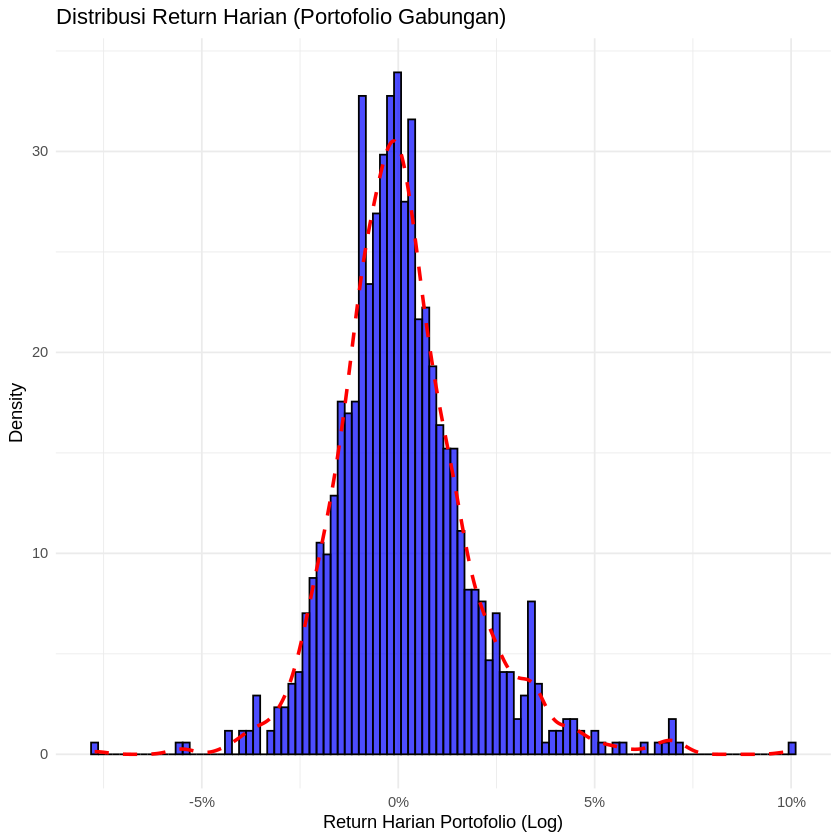

In [6]:
# Hitung return portofolio historis
portfolio_returns_df <- returns_data_wide %>%
  mutate(portfolio_return = (PTBA.JK * bobot[1]) + (SMBR.JK * bobot[2]) + (RMKE.JK * bobot[3]))

# Plot 2: Histogram + Density Plot dari Portofolio Gabungan
plot_hist_portfolio <- ggplot(portfolio_returns_df, aes(x = portfolio_return)) +
  geom_histogram(aes(y = after_stat(density)), bins = 100, fill = "blue", color = "black", alpha = 0.7) +
  geom_density(color = "red", linewidth = 1, linetype = "dashed") +
  labs(title = "Distribusi Return Harian (Portofolio Gabungan)",
       x = "Return Harian Portofolio (Log)",
       y = "Density") +
  scale_x_continuous(labels = scales::percent) + # Tampilkan sebagai %
  theme_minimal()

suppressWarnings(print(plot_hist_portfolio))

In [14]:
# ESTIMASI DERAJAT KEBEBASAN OPTIMAL MENGGUNAKAN MLE (Maximum Likelihood Estimation)
# Estimasi kemungkinan Maksimum

suppressMessages(library(MASS))  # untuk memakai fungsi fitdistr()
                                  # fungsi fitdistr() ini digunakan untuk mencocokan data pada suatu distribusi (disini memakai distribusi-t)

cat("ESTIMASI PARAMETER DISTRIBUSI-T (MLE)\n")
cat("===============================================\n")

# Hitung return portofolio historis
portfolio_returns_historical <- portfolio_returns_df$portfolio_return

# Fit distribusi-t menggunakan Maximum Likelihood
fit_t <- suppressWarnings(fitdistr(portfolio_returns_historical, "t"))

# Ekstrak parameter
df_optimal <- fit_t$estimate["df"]
location <- fit_t$estimate["m"]
scale <- fit_t$estimate["s"]

cat(paste("Derajat Kebebasan (df) optimal:", round(df_optimal, 2), "\n"))
cat(paste("Location (mean):", round(location, 6), "\n"))
cat(paste("Scale (volatility):", round(scale, 6), "\n"))
cat(paste("Standard Error df:", round(fit_t$sd["df"], 2), "\n"))

# Update df untuk simulasi
df <- round(df_optimal)
cat(paste("df yang akan digunakan untuk simulasi:", df, "\n"))

ESTIMASI PARAMETER DISTRIBUSI-T (MLE)
Derajat Kebebasan (df) optimal: 4.03 
Location (mean): -0.000338 
Scale (volatility): 0.012343 
Standard Error df: 0.57 
df yang akan digunakan untuk simulasi: 4 


In [8]:
# Menentukan Derajat Kebebasan untuk distribusi-t
df <- 4

# FUNGSI ACCEPTANCE-REJECTION :
# Target: Distribusi-t Student dengan df derajat kebebasan
# Proposal: Distribusi Cauchy (lebih mudah dibangkitkan)

# INVERSE TRANSFORM METHOD :
# Untuk membangkitkan uniform(0,1) yang digunakan di acceptance-rejection

acceptance_rejection_t <- function(n, df) {
  # Konstanta normalisasi untuk acceptance-rejection
  # mengunakan Cauchy sebagai proposal distribution
  # f(x) = target density (t-distribution)
  # g(x) = proposal density (Cauchy)
  # M = konstanta sehingga f(x) <= M * g(x) untuk semua x

  M <- sqrt((df + 1) / df) * gamma((df + 1)/2) / gamma(df/2)

  samples <- numeric(n)
  accepted <- 0
  total_attempts <- 0

  while(accepted < n) {
    # 1. Bangkitkan kandidat dari Cauchy menggunakan INVERSE TRANSFORM
    u <- runif(1)
    y <- tan(pi * (u - 0.5))  # Inverse CDF dari Cauchy

    # 2. Hitung rasio acceptance
    # Density t-distribution
    f_y <- dt(y, df)
    # Density Cauchy
    g_y <- 1 / (pi * (1 + y^2))

    # 3. Acceptance step
    u2 <- runif(1)
    if (u2 <= (f_y / (M * g_y))) {
      accepted <- accepted + 1
      samples[accepted] <- y
    }

    total_attempts <- total_attempts + 1
  }

  acceptance_rate <- n / total_attempts
  cat(paste("Tingkat Penerimaan:", round(acceptance_rate * 100, 2), "%\n"))

  return(list(samples = samples, rate = acceptance_rate))
}

# Hitung faktor standardisasi untuk t-distribution
t_variance <- df / (df - 2)
t_sd <- sqrt(t_variance)

cat("SIMULASI MENGGUNAKAN ACCEPTANCE-REJECTION\n")
cat("===========================================\n")
cat(paste("Jumlah simulasi:", jumlah_simulasi, "\n"))
cat(paste("Derajat kebebasan (df):", df, "\n"))
cat(paste("Jumlah hari:", jumlah_hari, "\n\n"))

# Hitung Dekomposisi Cholesky untuk struktur korelasi
# Ukuran matriks 3 x 3
cholesky_decomp <- chol(cov_matrix)

all_acceptance_rates <- numeric(jumlah_simulasi)

# Jalankan simulasi menggunakan Acceptance-Rejection
simulation_results <- sapply(1:jumlah_simulasi, function(sim) {

  if (sim %% 1000 == 0) {
    cat(paste("Simulasi ke-", sim, "...\n"))
  }
  result_list <- acceptance_rejection_t(jumlah_hari * banyak_aset, df)
  all_acceptance_rates[sim] <<- result_list$rate

  # Bangkitkan return acak INDEPENDEN menggunakan ACCEPTANCE-REJECTION
  # Ukuran matriks 30 x 3
  uncorrelated_randoms <- matrix(
    result_list$samples,
    nrow = jumlah_hari,
    ncol = banyak_aset
  )

  # Standarisasi agar variansi = 1
  standardized_randoms <- uncorrelated_randoms / t_sd

  # Masukkan korelasi menggunakan Cholesky decomposition
  # Ukuran Martiks 30 x 3
  simulated_returns <- (standardized_randoms %*% cholesky_decomp) +
                        matrix(mean_returns,
                               nrow = jumlah_hari,
                               ncol = banyak_aset,
                               byrow = TRUE)

  # Hitung return portofolio harian
  # Ukuran matriks 30 x 1
  portfolio_returns <- simulated_returns %*% bobot

  # Hitung nilai akhir portofolio
  nilai_final <- portofolio_awal * exp(sum(portfolio_returns))

  return(nilai_final)
})

cat("SIMULASI SELESAI\n")

# Hitung Rata-rata Total
rata_rata_rate <- mean(all_acceptance_rates)

cat("========================================\n")
cat("VALIDASI ALGORITMA:\n")
cat(paste("Rata-rata Acceptance Rate (Empiris):", round(rata_rata_rate * 100, 4), "%\n"))

Output streaming akan dipotong hingga 5000 baris terakhir.
Tingkat Penerimaan: 68.18 %
Tingkat Penerimaan: 67.67 %
Tingkat Penerimaan: 70.87 %
Tingkat Penerimaan: 69.23 %
Tingkat Penerimaan: 72 %
Tingkat Penerimaan: 68.18 %
Tingkat Penerimaan: 70.87 %
Tingkat Penerimaan: 68.7 %
Tingkat Penerimaan: 69.23 %
Tingkat Penerimaan: 58.82 %
Tingkat Penerimaan: 73.77 %
Tingkat Penerimaan: 65.22 %
Tingkat Penerimaan: 64.75 %
Tingkat Penerimaan: 64.29 %
Tingkat Penerimaan: 62.94 %
Tingkat Penerimaan: 69.23 %
Tingkat Penerimaan: 68.18 %
Tingkat Penerimaan: 60.81 %
Tingkat Penerimaan: 73.77 %
Tingkat Penerimaan: 69.77 %
Tingkat Penerimaan: 68.7 %
Tingkat Penerimaan: 72 %
Tingkat Penerimaan: 70.87 %
Tingkat Penerimaan: 65.22 %
Tingkat Penerimaan: 66.67 %
Tingkat Penerimaan: 65.22 %
Tingkat Penerimaan: 68.18 %
Tingkat Penerimaan: 68.18 %
Tingkat Penerimaan: 64.75 %
Tingkat Penerimaan: 62.94 %
Tingkat Penerimaan: 66.18 %
Tingkat Penerimaan: 57.32 %
Tingkat Penerimaan: 65.22 %
Tingkat Penerimaan: 62.5 

In [9]:
print(cholesky_decomp)

          PTBA.JK     SMBR.JK      RMKE.JK
PTBA.JK 0.0208231 0.002858605 0.0020002669
SMBR.JK 0.0000000 0.027498653 0.0004079326
RMKE.JK 0.0000000 0.000000000 0.0339036954


## Penjelasan Metode Acceptance-Rejection

**Konsep Dasar:**

Acceptance-Rejection adalah metode untuk membangkitkan bilangan acak dari distribusi target f(x) yang sulit dibangkitkan secara langsung, dengan menggunakan distribusi proposal g(x) yang lebih mudah.

**Langkah-langkah:**

1. **Pilih proposal distribution g(x)**: Dalam kasus ini, kita gunakan Cauchy karena:
   - Mudah dibangkitkan menggunakan Inverse Transform: Y = tan(π(U - 0.5))
   - Memiliki ekor tebal seperti distribusi-t
   - Dapat dibangkitkan secara analitis

2. **Tentukan konstanta M**: Sehingga f(x) ≤ M·g(x) untuk semua x
   - M = √((df+1)/df) · Γ((df+1)/2) / Γ(df/2)

3. **Generate kandidat**:
   - Bangkitkan Y ~ g(x) menggunakan Inverse Transform
   - Bangkitkan U ~ Uniform(0,1)

4. **Tes penerimaan**:
   - Jika U ≤ f(Y)/(M·g(Y)), terima Y
   - Jika tidak, tolak dan ulangi

## Penjelasan Metode Inverse Transform

**Konsep Dasar:**

Inverse Transform Method (Metode Transformasi Invers) adalah teknik fundamental untuk membangkitkan bilangan acak dari distribusi kontinu F(x).

**Teorema:**

Jika U ~ Uniform(0,1) dan X = F⁻¹(U), maka X ~ F

**Aplikasi dalam Penelitian Ini:**

1. **Untuk distribusi Uniform**: Menggunakan generator bawaan R (runif)

2. **Untuk distribusi Cauchy**:
   - CDF: F(x) = (1/π)arctan(x) + 1/2
   - Inverse CDF: F⁻¹(u) = tan(π(u - 1/2))
   - Langkah: Bangkitkan U ~ Uniform(0,1), lalu Y = tan(π(U - 0.5))

**Dalam Konteks Acceptance-Rejection:**
Inverse Transform digunakan untuk membangkitkan:
- Bilangan uniform U ~ Uniform(0,1) untuk acceptance test
- Kandidat dari distribusi Cauchy sebagai proposal distribution

HASIL ANALISIS RISIKO PORTOFOLIO
Metode: Acceptance-Rejection + Inverse Transform
Modal Awal: Rp 1e+08 
Nilai Portofolio Rata-Rata: Rp 103,286,073 
Standar Deviasi: Rp 9,511,140 
Value at Risk (VaR) 95%: Rp 11,434,680 

INTERPRETASI:
Ada 5% kemungkinan Anda akan rugi LEBIH DARI Rp 11,434,680 dalam 30 hari.
Atau dengan 95% keyakinan, kerugian maksimum adalah Rp 11,434,680 



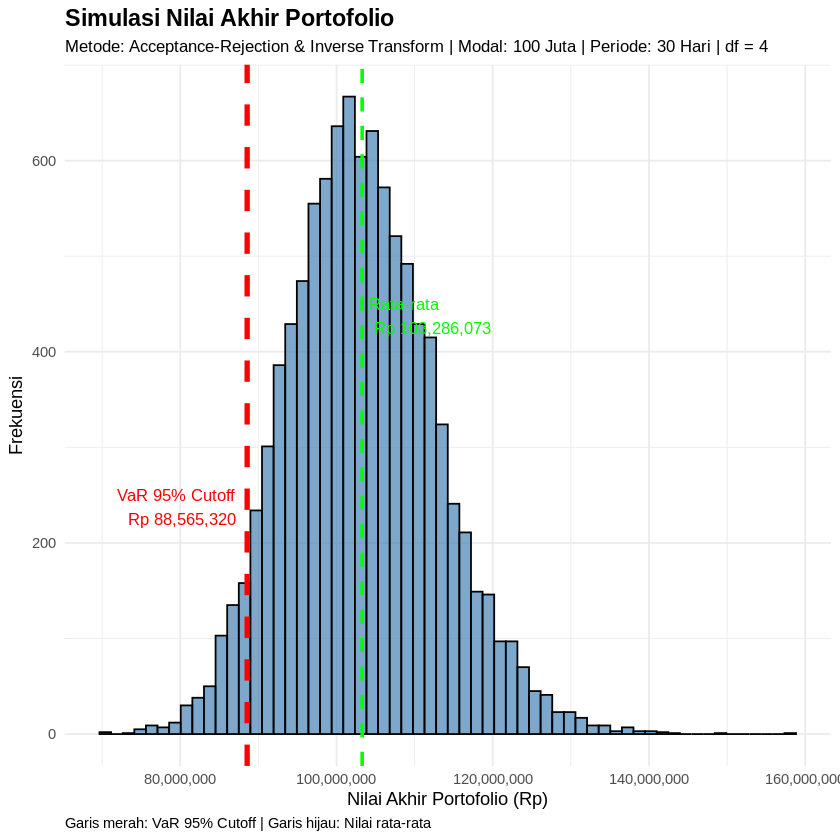

In [10]:
# ANALISIS HASIL (VaR & PLOTTING)

set.seed(432)
results_df <- data.frame(nilai_final = simulation_results)
results_df$loss <- portofolio_awal - results_df$nilai_final

# Hitung VaR 95%
var_95 <- quantile(results_df$loss, probs = 0.95)

cat("HASIL ANALISIS RISIKO PORTOFOLIO\n")
cat("===========================================\n")
cat(paste("Metode: Acceptance-Rejection + Inverse Transform\n"))
cat(paste("Modal Awal: Rp", format(portofolio_awal, big.mark = ",")),"\n")
cat(paste("Nilai Portofolio Rata-Rata: Rp", format(mean(results_df$nilai_final), big.mark = ",", nsmall = 0)),"\n")
cat(paste("Standar Deviasi: Rp", format(sd(results_df$nilai_final), big.mark = ",", nsmall = 0)),"\n")
cat(paste("Value at Risk (VaR) 95%: Rp", format(var_95, big.mark = ",", nsmall = 0)),"\n")
cat("\n")
cat("INTERPRETASI:\n")
cat(paste("Ada 5% kemungkinan Anda akan rugi LEBIH DARI Rp", format(var_95, big.mark = ",", nsmall = 0), "dalam 30 hari.\n"))
cat(paste("Atau dengan 95% keyakinan, kerugian maksimum adalah Rp", format(var_95, big.mark = ",", nsmall = 0), "\n"))
cat("===========================================\n\n")

# Visualisasi
var_cutoff_value <- portofolio_awal - var_95
plot <- ggplot(results_df, aes(x = nilai_final)) +
  geom_histogram(bins = 60, fill = "steelblue", alpha = 0.7, color = "black") +
  geom_vline(xintercept = var_cutoff_value, color = "red", linetype = "dashed", linewidth = 1.5) +
  geom_vline(xintercept = mean(results_df$nilai_final), color = "green", linetype = "dashed", linewidth = 1) +
  labs(title = "Simulasi Nilai Akhir Portofolio",
       subtitle = "Metode: Acceptance-Rejection & Inverse Transform | Modal: 100 Juta | Periode: 30 Hari | df = 4",
       x = "Nilai Akhir Portofolio (Rp)",
       y = "Frekuensi",
       caption = "Garis merah: VaR 95% Cutoff | Garis hijau: Nilai rata-rata") +
  annotate("text",
           x = var_cutoff_value,
           y = 200,
           label = paste("VaR 95% Cutoff\nRp", format(var_cutoff_value, big.mark = ",", nsmall = 0)),
           color = "red", vjust = -0.5, hjust = 1.1, size = 3.5) +
  annotate("text",
           x = mean(results_df$nilai_final),
           y = 400,
           label = paste("Rata-rata\nRp", format(mean(results_df$nilai_final), big.mark = ",", nsmall = 0)),
           color = "green", vjust = -0.5, hjust = -0.1, size = 3.5) +
  scale_x_continuous(labels = scales::comma) +
  theme_minimal() +
  theme(plot.title = element_text(face = "bold", size = 14),
        plot.subtitle = element_text(size = 10),
        plot.caption = element_text(hjust = 0))

suppressWarnings(print(plot))

## Interpretasi Value at Risk (VaR)

**Sisi 95% (Keyakinan):**

Dalam 95% dari 10,000 skenario yang disimulasikan menggunakan metode Acceptance-Rejection, kerugian akan lebih kecil dari nilai VaR yang dihitung, atau bahkan portofolio akan mengalami keuntungan (seperti nilai rata-rata yang umumnya positif).

**Sisi 5% (Risiko Ekstrem):**

VaR 95% menandai batas "worst-case scenario" untuk 95% kepercayaan. Ada 5% kemungkinan kerugian akan melebihi nilai VaR. Namun, VaR tidak memberitahu seberapa besar kerugian di luar threshold tersebut.

**Keunggulan Metode yang Digunakan:**

1. **Acceptance-Rejection Method**: Menghasilkan sampel exact dari distribusi-t Student tanpa aproksimasi
2. **Inverse Transform Method**: Memberikan fondasi matematis yang solid untuk pembangkitan bilangan acak
3. **Distribusi-t Student**: Menangkap fat-tails dan extreme events lebih baik daripada distribusi normal
4. **Simulasi Berbasis**: Memberikan distribusi lengkap hasil (bukan hanya point estimate)

**Catatan Penting:**

Metode ini BUKAN Monte Carlo klasik yang menggunakan built-in random generators, melainkan implementasi eksplisit dari:
- Inverse Transform untuk membangkitkan Uniform dan Cauchy
- Acceptance-Rejection untuk membangkitkan distribusi-t dari proposal Cauchy
- Cholesky decomposition untuk struktur korelasi antar aset

## Visualisasi Metode Acceptance-Rejection

Mari visualisasikan bagaimana metode Acceptance-Rejection bekerja dengan membandingkan distribusi target (t-Student) dengan proposal (Cauchy).


Theoretical Acceptance Rate: 67.28 %


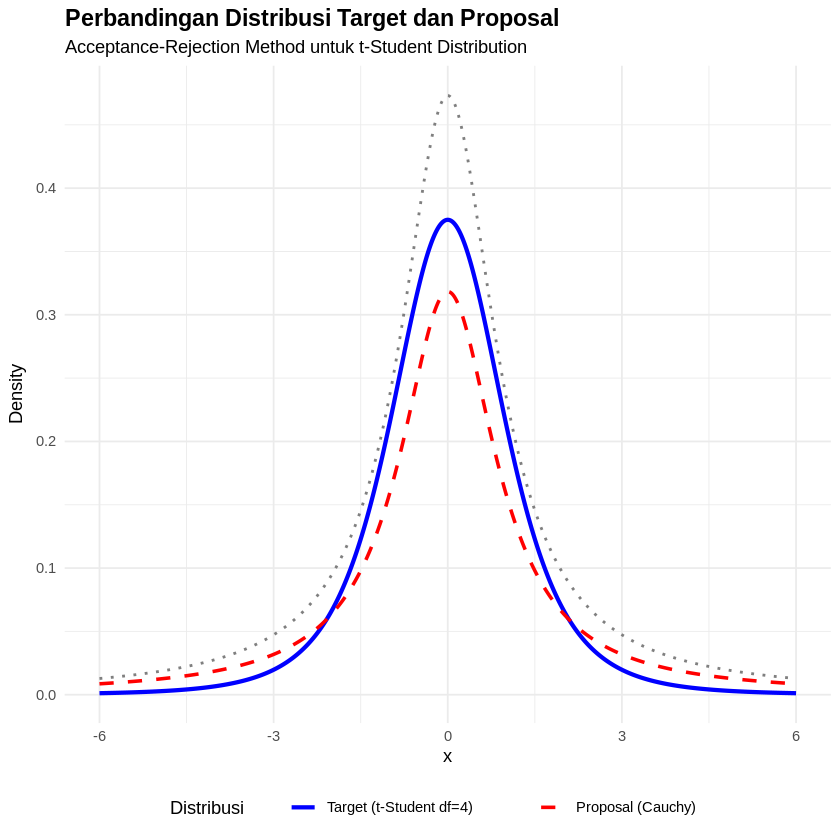

In [11]:
# VISUALISASI PERBANDINGAN DISTRIBUSI

# Buat grid untuk plotting
x <- seq(-6, 6, length.out = 1000)

# Hitung densitas distribusi target (t-Student)
target_density <- dt(x, df = df)

# Hitung densitas proposal (Cauchy)
cauchy_density <- dcauchy(x)

# Hitung M (konstanta envelope)
M <- sqrt((df + 1) / df) * gamma((df + 1)/2) / gamma(df/2)

# Buat dataframe untuk plotting
comparison_df <- data.frame(
  x = x,
  target = target_density,
  proposal = cauchy_density,
  envelope = M * cauchy_density
)

# Plot perbandingan distribusi
envelope_label <- paste0("Envelope (M*Cauchy, M=", round(M, 2), ")")

plot_comparison <- ggplot(comparison_df, aes(x = x)) +
  geom_line(aes(y = target, color = "Target (t-Student df=4)"), linewidth = 1.2) +
  geom_line(aes(y = proposal, color = "Proposal (Cauchy)"), linewidth = 1, linetype = "dashed") +
  geom_line(aes(y = envelope, color = envelope_label),
            linewidth = 0.8, linetype = "dotted") +
  scale_color_manual(
    name = "Distribusi",
    values = c("Target (t-Student df=4)" = "blue",
               "Proposal (Cauchy)" = "red",
               "Envelope (M*Cauchy, M=1.13)" = "green"),
    breaks = c("Target (t-Student df=4)", "Proposal (Cauchy)", envelope_label)
  ) +
  labs(title = "Perbandingan Distribusi Target dan Proposal",
       subtitle = "Acceptance-Rejection Method untuk t-Student Distribution",
       x = "x",
       y = "Density",
       color = "Distribusi") +
  theme_minimal() +
  theme(legend.position = "bottom",
        plot.title = element_text(face = "bold", size = 14))

suppressWarnings(print(plot_comparison))

# Hitung theoretical acceptance rate
theoretical_acceptance_rate <- 1 / M
cat(paste("\nTheoretical Acceptance Rate:", round(theoretical_acceptance_rate * 100, 2), "%\n"))

## Demonstrasi Inverse Transform Method

Mari kita demonstrasikan bagaimana Inverse Transform Method bekerja untuk distribusi Cauchy.

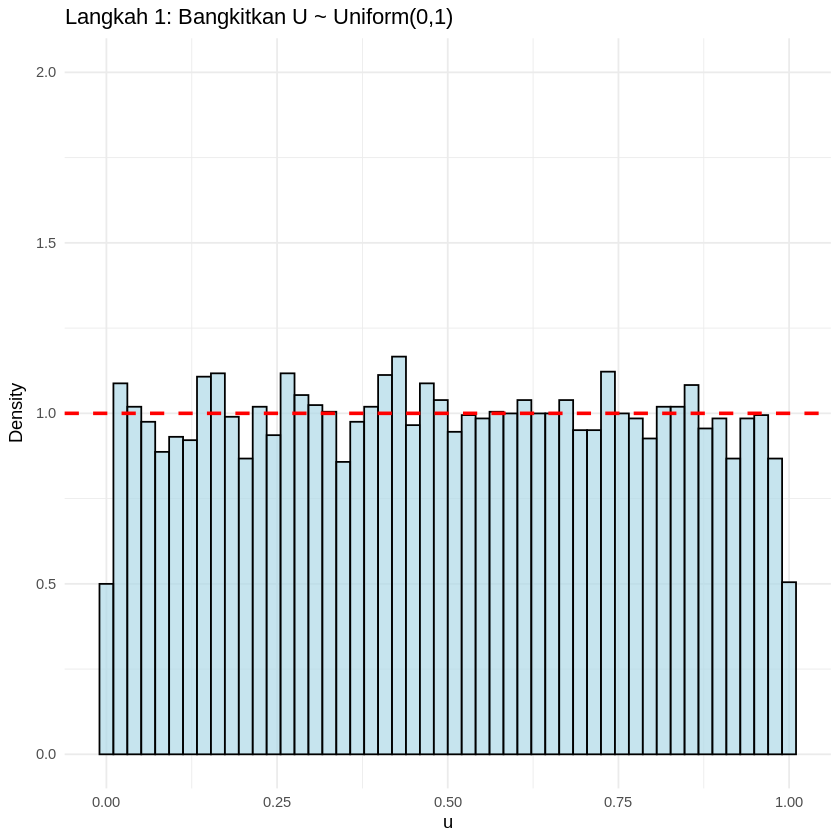


VERIFIKASI INVERSE TRANSFORM METHOD
Mean Cauchy (teoritis: 0): -0.0744 
Jumlah sampel: 10000 


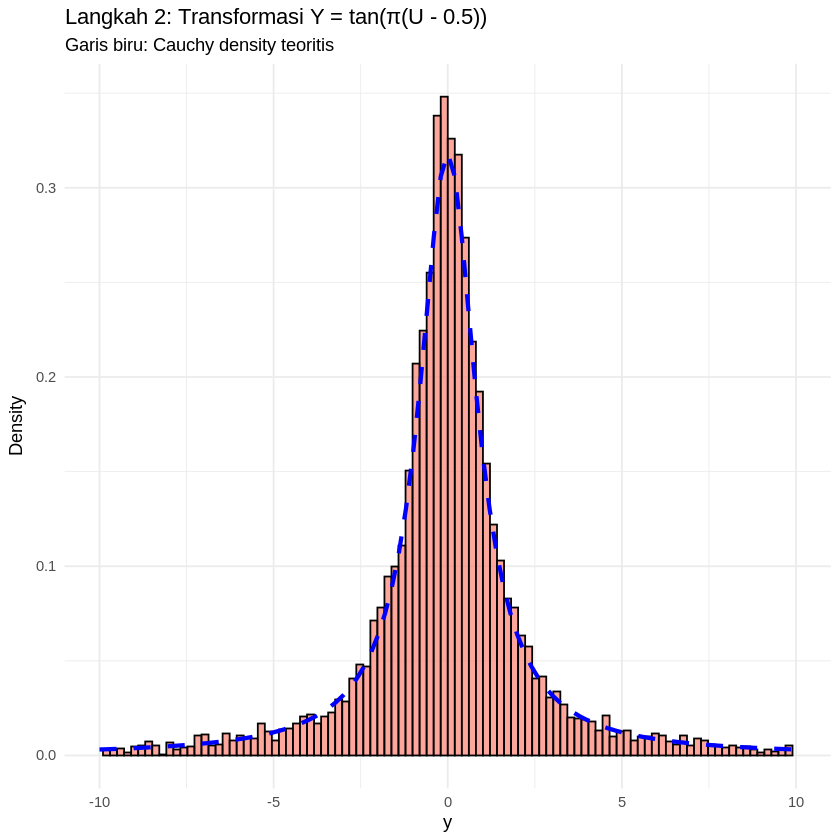

In [12]:
# DEMONSTRASI INVERSE TRANSFORM METHOD

set.seed(123)
n_demo <- 10000

# Bangkitkan bilangan uniform U(0,1)
u_samples <- runif(n_demo)

# Terapkan inverse CDF Cauchy: tan(π(u - 0.5))
cauchy_samples <- tan(pi * (u_samples - 0.5))

# Buat dataframe untuk plotting
demo_df <- data.frame(
  uniform = u_samples,
  cauchy = cauchy_samples
)

# Plot 1: Distribusi Uniform
plot_uniform <- ggplot(demo_df, aes(x = uniform)) +
  geom_histogram(aes(y = after_stat(density)), bins = 50, fill = "lightblue", color = "black", alpha = 0.7) +
  geom_hline(yintercept = 1, color = "red", linetype = "dashed", linewidth = 1) +
  labs(title = "Langkah 1: Bangkitkan U ~ Uniform(0,1)",
       x = "u",
       y = "Density") +
  ylim(0, 2) +
  theme_minimal()

# Plot 2: Transformasi ke Cauchy
plot_cauchy <- ggplot(demo_df, aes(x = cauchy)) +
  geom_histogram(aes(y = after_stat(density)), bins = 100, fill = "salmon", color = "black", alpha = 0.7) +
  stat_function(fun = dcauchy, color = "blue", linewidth = 1.2, linetype = "dashed") +
  xlim(-10, 10) +
  labs(title = "Langkah 2: Transformasi Y = tan(π(U - 0.5))",
       subtitle = "Garis biru: Cauchy density teoritis",
       x = "y",
       y = "Density") +
  theme_minimal()

# Tampilkan plot
suppressWarnings(print(plot_uniform))
cat("\n")
suppressWarnings(print(plot_cauchy))

cat("\n========================================\n")
cat("VERIFIKASI INVERSE TRANSFORM METHOD\n")
cat("========================================\n")
cat(paste("Mean Cauchy (teoritis: 0):", round(mean(cauchy_samples[abs(cauchy_samples) < 100]), 4), "\n"))
cat(paste("Jumlah sampel:", n_demo, "\n"))

## Ringkasan Metodologi

**(Acceptance-Rejection + Inverse Transform):**

1. **Inverse Transform Method**
   - Digunakan untuk membangkitkan U ~ Uniform(0,1)
   - Digunakan untuk membangkitkan Cauchy: Y = tan(π(U - 0.5))
   - Formula analitis eksplisit

2. **Acceptance-Rejection Method**
   - Target: Distribusi-t Student (df = 4, sesuai hasil dari metode MLE)
   - Proposal: Distribusi Cauchy (lebih mudah dibangkitkan)
   - Konstanta (M) dihitung secara matematis
   - Tingkat penerimaan dimonitor dan dilaporkan


Tingkat Penerimaan: 67.42 %


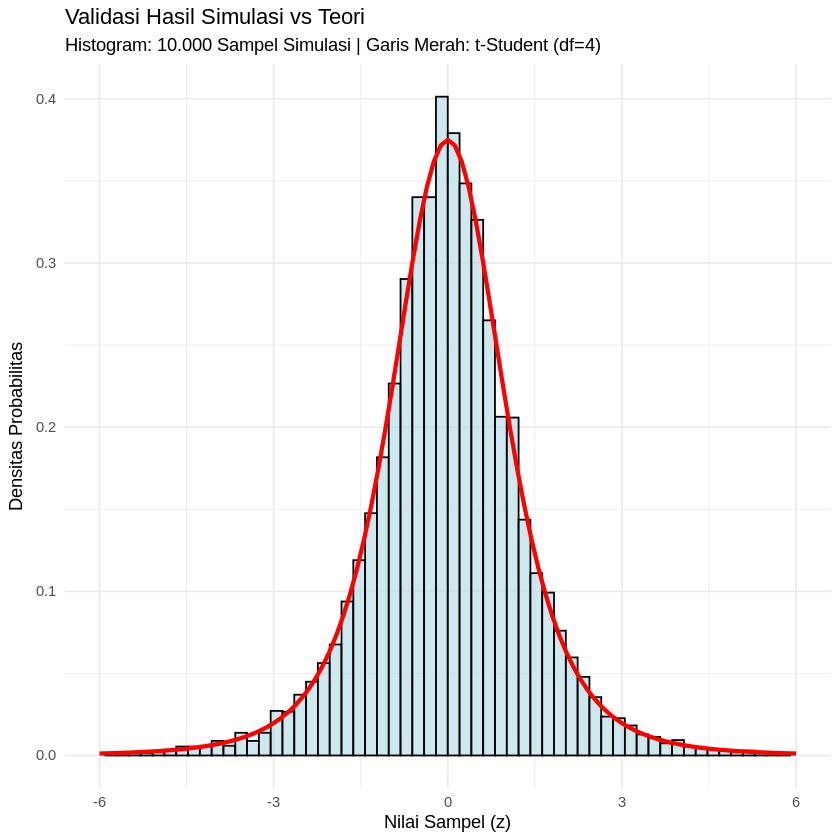

In [13]:
# 1. Ambil sampel dari fungsi yang sudah Anda buat
hasil_ar <- acceptance_rejection_t(10000, df=4)
sampel_simulasi <- hasil_ar$samples

# 2. Buat Dataframe
df_validasi <- data.frame(nilai = sampel_simulasi)

# 3. Plot Histogram (Data) vs Kurva Teoritis (Garis Merah)
suppressMessages(library(ggplot2))

plot_validasi <- ggplot(df_validasi, aes(x = nilai)) +
  # A. Histogram dari data simulasi (Empiris)
  geom_histogram(aes(y = after_stat(density)), bins = 60,
                 fill = "lightblue", color = "black", alpha = 0.6) +

  # B. Garis Kurva t-Student Teoritis (df=4)
  stat_function(fun = dt, args = list(df = 4),
                color = "red", linewidth = 1.2, linetype = "solid") +

  # C. Label dan Judul
  labs(title = "Validasi Hasil Simulasi vs Teori",
       subtitle = "Histogram: 10.000 Sampel Simulasi | Garis Merah: t-Student (df=4)",
       x = "Nilai Sampel (z)",
       y = "Densitas Probabilitas") +

  # D. Batasi sumbu X agar terlihat jelas (fokus ke tengah)
  xlim(-6, 6) +
  theme_minimal()

# 4. Simpan Gambar
suppressMessages(ggsave("validasi_t_student.png", plot = plot_validasi, width = 8, height = 5))
suppressWarnings(print(plot_validasi))